Dataset columns:
1. age: The person’s age in years
2. sex: The person’s sex (1 = male, 0 = female)
3. cp: chest pain type
— Value 0: asymptomatic
— Value 1: atypical angina
— Value 2: non-anginal pain
— Value 3: typical angina
4. trestbps: The person’s resting blood pressure (mm Hg on admission to the hospital)
5. chol: The person’s cholesterol measurement in mg/dl
6. fbs: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
7. restecg: resting electrocardiographic results
— Value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria
— Value 1: normal
— Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
8. thalach: The person’s maximum heart rate achieved
9. exang: Exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot. See more here)
11. slope: the slope of the peak exercise ST segment — 0: downsloping; 1: flat; 2: upsloping
0: downsloping; 1: flat; 2: upsloping
12. ca: The number of major vessels (0–3)
13. thal: A blood disorder called thalassemia Value 0: NULL (dropped from the dataset previously
Value 1: fixed defect (no blood flow in some part of the heart)
Value 2: normal blood flow
Value 3: reversible defect (a blood flow is observed but it is not normal)
14. target: Heart disease (1 = no, 0= yes)

In [39]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [40]:
df_heart = pd.read_csv('heart.csv')
df_heart = df_heart.rename(columns = {'target': 'heart_disease'})
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [41]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            303 non-null    int64  
 1   sex            303 non-null    int64  
 2   cp             303 non-null    int64  
 3   trestbps       303 non-null    int64  
 4   chol           303 non-null    int64  
 5   fbs            303 non-null    int64  
 6   restecg        303 non-null    int64  
 7   thalach        303 non-null    int64  
 8   exang          303 non-null    int64  
 9   oldpeak        303 non-null    float64
 10  slope          303 non-null    int64  
 11  ca             303 non-null    int64  
 12  thal           303 non-null    int64  
 13  heart_disease  303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [42]:
discrete = []
numerical = []

for column in df_heart.columns:
    if df_heart[column].nunique() < 10:
        discrete.append(column)
    else:
        numerical.append(column)

<AxesSubplot:>

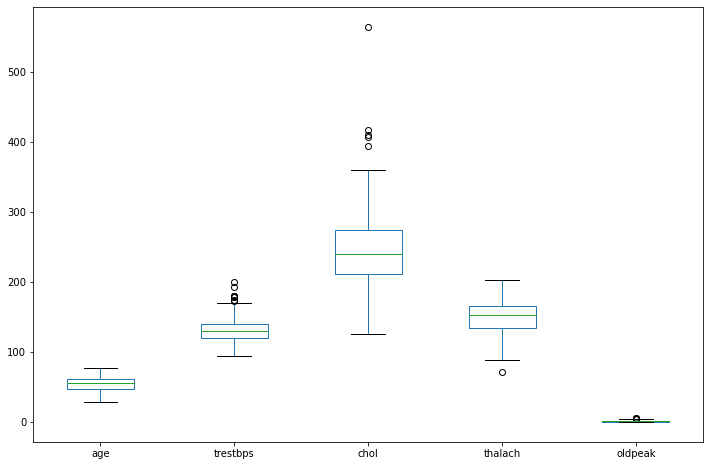

In [43]:
df_heart[numerical].plot.box(figsize = (12, 8))

In [44]:
def remove_outlier(column):
    q25 = column.quantile(0.25)
    q75 = column.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr * 1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

In [45]:
for column in numerical:
    lower, upper = remove_outlier(df_heart[column])
    df_heart = df_heart.loc[(df_heart[column] > lower) & (df_heart[column] < upper)]

<AxesSubplot:>

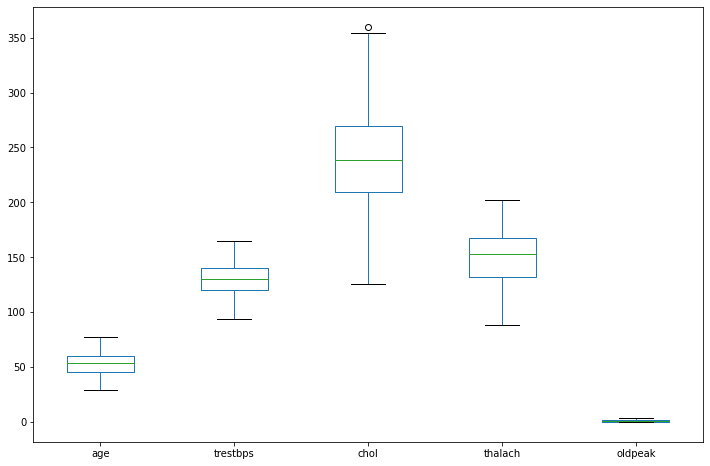

In [46]:
df_heart[numerical].plot.box(figsize = (12, 8))

In [47]:
df_heart.shape

(279, 14)

In [48]:
le = LabelEncoder()
for column in numerical[:-1]: 
    df_heart[column] = pd.qcut(df_heart[column], q = [0, 0.25, 0.50, 0.75, 1])
    df_heart[column] = le.fit_transform(df_heart[column])

In [49]:
df_heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,3,1,3,3,1,1,0,1,0,2.3,0,0,1,1
1,0,1,2,1,2,0,1,3,0,3.5,0,0,2,1
2,0,0,1,1,0,0,0,3,0,1.4,2,0,2,1
3,2,1,1,0,1,0,1,3,0,0.8,2,0,2,1
4,2,0,0,0,3,0,1,2,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2,0,0,2,2,0,1,0,1,0.2,1,0,3,0
299,0,1,3,0,2,0,1,0,0,1.2,1,0,3,0
300,3,1,0,3,0,1,1,1,0,3.4,1,2,3,0
301,2,1,0,1,0,0,1,0,1,1.2,1,1,3,0


In [50]:
X =  df_heart.drop('heart_disease', axis = 1)
y = df_heart['heart_disease']

In [51]:
chi2_check = []
for i in X.columns:
    if chi2_contingency(pd.crosstab(df_heart['heart_disease'], df_heart[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [X.columns, chi2_check]).T 
res.columns = ['Column', 'Hypothesis']
print(res)

      Column                      Hypothesis
0        age          Reject Null Hypothesis
1        sex          Reject Null Hypothesis
2         cp          Reject Null Hypothesis
3   trestbps  Fail to Reject Null Hypothesis
4       chol  Fail to Reject Null Hypothesis
5        fbs  Fail to Reject Null Hypothesis
6    restecg          Reject Null Hypothesis
7    thalach          Reject Null Hypothesis
8      exang          Reject Null Hypothesis
9    oldpeak          Reject Null Hypothesis
10     slope          Reject Null Hypothesis
11        ca          Reject Null Hypothesis
12      thal          Reject Null Hypothesis


In [52]:
res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']

0         age
1         sex
2          cp
6     restecg
7     thalach
8       exang
9     oldpeak
10      slope
11         ca
12       thal
Name: Column, dtype: object

In [53]:
X_selected = X[res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state = 0)

In [54]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
y_train.value_counts()

1    113
0     82
Name: heart_disease, dtype: int64

In [56]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

1    113
0    113
Name: heart_disease, dtype: int64

In [57]:
log_reg = LogisticRegression(random_state = 0)
svm_clf = SVC(random_state = 0)
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier(random_state = 0)

models = {'LogisticRegression': log_reg, 'SVC': svm_clf, 'KNeighborsClassifier': knn_clf, 'RandomForestClassifier': rf_clf}

In [58]:
def model_training_testing(models):
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_predict_trian = model.predict(X_train)
        y_predict_test = model.predict(X_test)
        print(f'{model_name} Training Accuracy:', accuracy_score(y_train, np.round(y_predict_trian)))
        print(f'{model_name} Testing Accuracy:', accuracy_score(y_test, np.round(y_predict_test)))
        print('\n')

In [59]:
model_training_testing(models)

LogisticRegression Training Accuracy: 0.8628318584070797
LogisticRegression Testing Accuracy: 0.8571428571428571


SVC Training Accuracy: 0.9247787610619469
SVC Testing Accuracy: 0.8452380952380952


KNeighborsClassifier Training Accuracy: 0.8761061946902655
KNeighborsClassifier Testing Accuracy: 0.8214285714285714


RandomForestClassifier Training Accuracy: 1.0
RandomForestClassifier Testing Accuracy: 0.8333333333333334




In [60]:
params = {'n_estimators': np.arange(10, 100, 10), 'random_state': [0], 'n_jobs': [1, -1]} 
grid_search = GridSearchCV(RandomForestClassifier(), params, n_jobs = -1, cv = 5)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

RandomForestClassifier(n_estimators=90, n_jobs=1, random_state=0)

In [61]:
rf_clf_tuned = RandomForestClassifier(n_estimators = 90, n_jobs = 1, random_state = 0)

In [62]:
rf_clf_tuned.fit(X_train, y_train)

RandomForestClassifier(n_estimators=90, n_jobs=1, random_state=0)

In [63]:
def model_evaluation(model, X, y, model_name):
    y_predict = model.predict(X)
    print(f'Model: {model_name} \n \n Classification Report: {classification_report(y, y_predict)}')

    cnf_matrix = confusion_matrix(y, y_predict)
    class_names = [0, 1]
    tick_marks = np.arange(len(class_names))
    plt.figure(figsize = (9, 7))

    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt = 'g')

    plt.tight_layout()
    plt.title(f'{model_name} Confusion Matrix', y = 1.1, fontsize = 22)
    plt.ylabel('Actual Label', fontsize = 15)
    plt.xlabel('Predicted Label', fontsize = 15)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

Model: Random Forest Classifier Tuned 
 
 Classification Report:               precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.82      0.89      0.85        45

    accuracy                           0.83        84
   macro avg       0.84      0.83      0.83        84
weighted avg       0.84      0.83      0.83        84



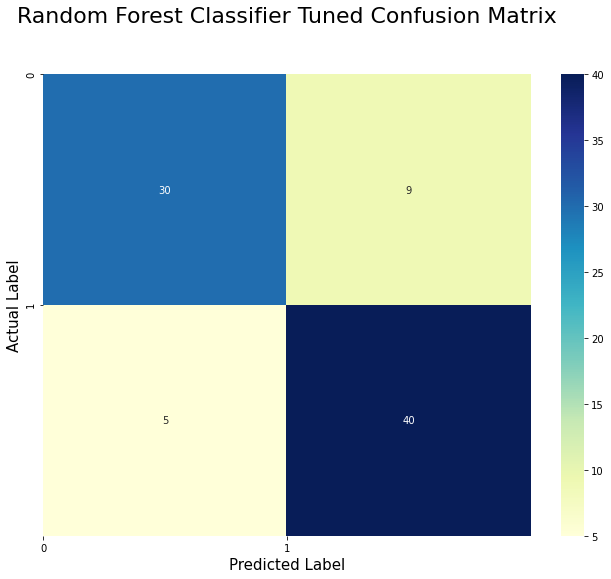

In [64]:
model_evaluation(rf_clf_tuned, X_test, y_test, model_name = 'Random Forest Classifier Tuned')

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob = rf_clf_tuned.predict_proba(X_test)[:, 1]
print(f'Area Under the Curve Score: {roc_auc_score(y_test, y_pred_prob)}')

Area Under the Curve Score: 0.9034188034188033


In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

df_roc = pd.DataFrame([fpr, tpr]).T
df_roc.columns = ['False Positive Ratio', 'True Positive Ratio']

import plotly.express as px

fig = px.line(df_roc, x = 'False Positive Ratio', y = 'True Positive Ratio')
fig.update_layout(title = dict(text = "ROC Curve.", y = 0.95, x = 0.5, 
                               xanchor = 'center', yanchor = 'top', font = dict(size = 20)))

According to the ROC Curve, an ideal threshold would be 0.5333 recurring from the set 0.5 sigmoid threshold. This would enable the model to make better heart disease detection as a result.

In [67]:
pickle.dump(rf_clf_tuned, open("classification_model.pkl", "wb"))

### Bonus

Implementing threshold change:

In [68]:
y_pred = []
for prob in y_pred_prob:
    if prob > 0.4667:
        y_pred.append(1)
    else:
         y_pred.append(0)
y_pred = np.array(y_pred)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78        39
           1       0.78      0.89      0.83        45

    accuracy                           0.81        84
   macro avg       0.82      0.80      0.81        84
weighted avg       0.81      0.81      0.81        84



In [70]:
print(classification_report(y_test, rf_clf_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.82      0.89      0.85        45

    accuracy                           0.83        84
   macro avg       0.84      0.83      0.83        84
weighted avg       0.84      0.83      0.83        84

